## **Forecasting Airline Miles Using Exponential Smoothing in Python**

#### In this project, I aimed to forecast airline miles using a time series forecasting technique known as Exponential Smoothing. The dataset used for this project was sourced from a Udemy course, providing a practical application of the concepts learned.

### **What is Exponential Smoothing?**
#### Exponential smoothing is a time series forecasting method for univariate data. It is particularly effective when the data exhibits trends and seasonality. The idea behind exponential smoothing is to give more weight to recent observations while gradually decreasing the weights for older observations. This method helps in smoothing out noise and making the forecast more responsive to recent changes in the data.
#### There are three main types of exponential smoothing:
#### **1.	Simple Exponential Smoothing:** This method is used when the data has no trend or seasonality. It applies a constant smoothing factor to the entire series, making it ideal for series that are stationary over time.
#### **2.	Holt’s Linear Trend Model:** This model extends simple exponential smoothing to capture linear trends in the data. It includes a trend component in addition to the level component, allowing the model to forecast data with a trend.
#### **3.	Holt-Winters Seasonal Model:** This is an extension of Holt’s model, which also incorporates a seasonal component. The Holt-Winters model is suitable for data with both trend and seasonality, and it can handle both additive and multiplicative seasonality depending on the nature of the data.


#### **Dataset and Initial Exploration**
#### The dataset consisted of monthly airline miles traveled from 1996 to 2005. I started by loading the dataset and performing basic exploratory data analysis (EDA) to understand the underlying patterns in the data.

#### The first block of code loads the airline miles data from a CSV file into a pandas DataFrame. It sets the Date column as the index and parses it as a datetime object to ensure correct handling of dates.

In [1]:
import pandas as pd
df = pd.read_csv("airmiles.csv",
                 index_col = "Date",
                 parse_dates = True,
                 dayfirst = True)
df.head()

,airmiles
Date,
1996-01-01,30983174
1996-02-01,32147663
1996-03-01,38342975
1996-04-01,35969113
1996-05-01,36474391


#### The second block of code sets the frequency of the time series data to monthly, specifically at the start of each month. This ensures that the data is treated as a regularly spaced monthly time series, which is essential for accurate time series analysis.

In [2]:
df = df.asfreq("MS")
df.head()

,airmiles
Date,
1996-01-01,30983174
1996-02-01,32147663
1996-03-01,38342975
1996-04-01,35969113
1996-05-01,36474391


#### Then I plotted the time series data for visual inspection and following observations were made:
#### 1- There is a clear upward trend in the data, indicating that the number of airline miles traveled generally increased over time. 
#### 2- The plot also displays a repeating pattern within each year, suggesting the presence of seasonality. This could indicate higher airline travel during certain months (e.g., holidays or vacation seasons).
#### 3- The variability or fluctuations in the airline miles seem to increase over time. This is evident as the peaks and troughs become more pronounced as the series progresses.
#### This all means that time series is non-stationary

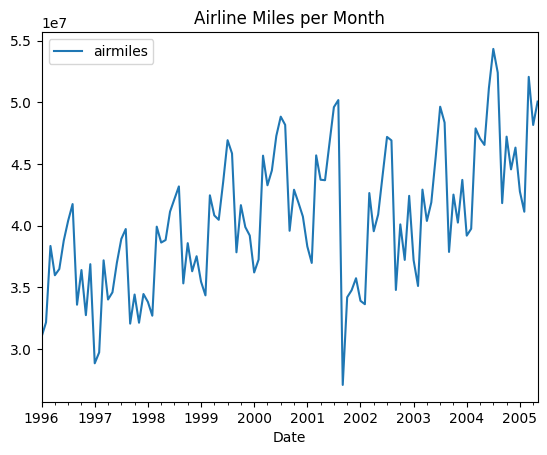

In [3]:
import matplotlib.pyplot as plt
df.plot(title="Airline Miles per Month")
plt.show()

#### Then time series was decomposed into its components to analyze the underlying patterns. For this purpose i chose traditional decompostion method, but I decomposed it in both ways "Multiplicative" and "Additive". Because **multiplicative** model is suitable when the seasonal fluctuations increase or decrease with the level of the time series. This is when the seasonal effect is proportional to the trend. **Additive** model is suitable when the seasonal variations are roughly constant throughout the series, regardless of the level of the trend. So to get a clear picture this was done.

#### It was aobserved that both decompositions showed same results expect for Residuals.


#### **Multipicative Seasonal Decomposition**:
#### The residuals are fairly consistent and clustered around a value close to 1, indicating that the multiplicative model has successfully captured most of the trend and seasonality. 

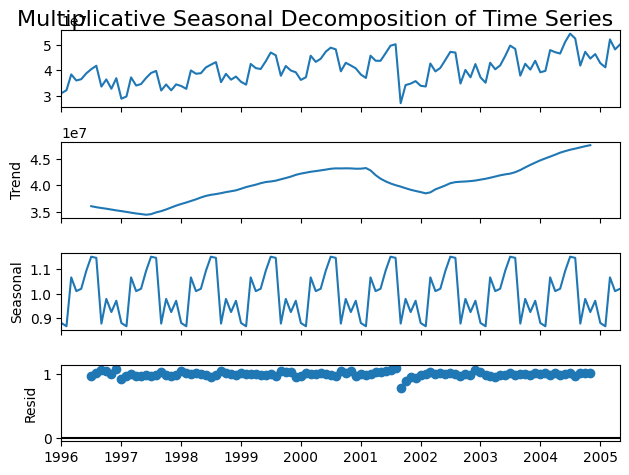

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_1 = seasonal_decompose(df, model="multiplicative", period=12)
fig = decomposition_1.plot()
fig.suptitle('Multiplicative Seasonal Decomposition of Time Series', fontsize=16)
plt.show()

#### **Additive Seasonal Decomposition**:
#### The residuals vary more significantly and are not centered around zero as nicely as we would expect for a well-fitted model. This suggests that the additive model does not capture the trend and seasonality as effectively as the multiplicative model.

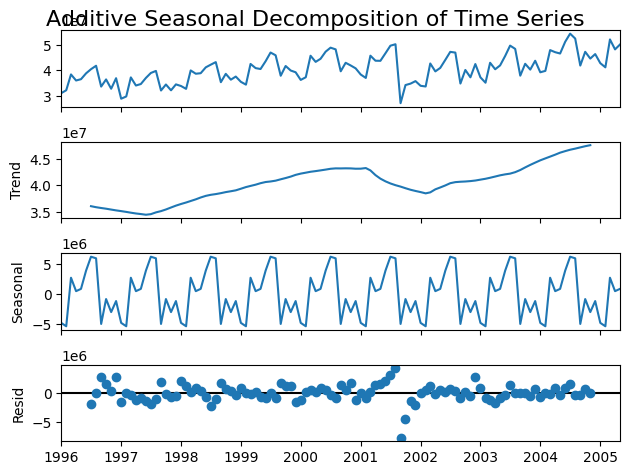

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_2 = seasonal_decompose(df, model="additive", period=12)
fig = decomposition_2.plot()
fig.suptitle('Additive Seasonal Decomposition of Time Series', fontsize=16)
plt.show()

#### **Plotting and analyzing is Auto-correlation Plot (ACF)** is another usefull technique to identify the presence of seasonality and trends in the data. Following observations were made from it.

#### The ACF plot reveals several important characteristics of the airline miles time series. It shows a very high positive correlation at lag 1, indicating that the miles traveled in one month are strongly correlated with those in the previous month. The autocorrelation gradually decreases over several lags before eventually turning negative, a pattern typical of non-stationary time series with a trend. Additionally, the spikes in the ACF at regular intervals, such as around lags 12 and 24, suggest the presence of a seasonal component, likely reflecting a yearly periodic pattern given the monthly data. The significant correlations at various lags outside the confidence interval indicate that past values have a substantial influence on the current values, highlighting the need to consider both trend and seasonality in any forecasting model.

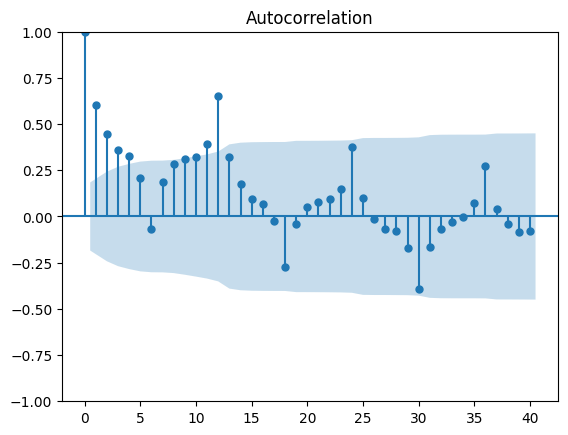

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df, lags=40)
plt.show()

#### **The Partial Autocorrelation Function (PACF)** plot helps to identify the direct relationship between a time series and its lags after removing the effects of intermediate lags. Here’s what the PACF plot indicated:

#### The PACF plot shows a very high positive correlation at lag 1, indicating that the current month's airline miles are strongly influenced by the previous month's values, reflecting a direct relationship with the first lag. There are significant spikes at several lags, particularly around lags 2, 3, 6, 7, 11, and 13, which suggests that these lags have a direct influence on the current value even after accounting for other intermediate lags. The alternating positive and negative significant spikes, especially at lags 6, 7, and 13, may indicate oscillatory behavior or seasonality in the data, suggesting that the series tends to revert or exhibit cyclical patterns after certain periods. After the initial spike at lag 1, the PACF values decrease and mostly stay within the confidence interval, indicating that the influence of further lags becomes less direct beyond the first few lags.

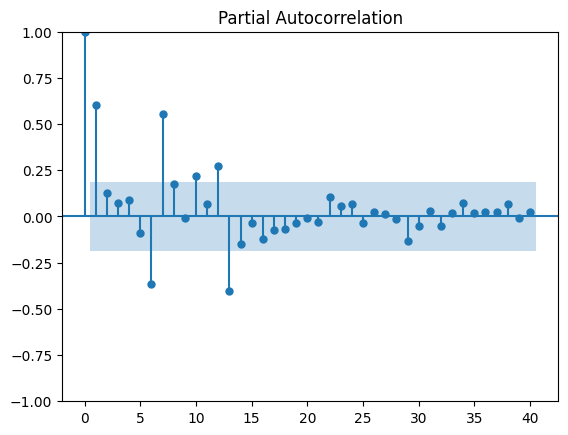

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df, lags=40)
plt.show()

#### **How ACF and PACF helped me in chosing Holts-Winter Model?**
#### The ACF and PACF plots suggest using the Holt-Winters method because the ACF indicates the presence of both trend and seasonality, with slow decay and significant correlations at regular intervals. The PACF shows significant spikes at specific lags, pointing to direct influences and potential oscillatory behavior. Together, these features highlight the need for a model like Holt-Winters, which effectively incorporates trend and seasonal components to capture the patterns in the data.

### **Holts-Winter Method**

#### First the dataset was split into training and test sets, with the last 12 months of data being assigned to the test set for model evaluation.

In [24]:
# training and test split, test set is for 12 months
train = df.iloc[:-12]
test = df.iloc[-12:]
test

,airmiles
Date,
2004-06-01,51134050
2004-07-01,54317314
2004-08-01,52392985
2004-09-01,41816777
2004-10-01,47205665
2004-11-01,44553653
2004-12-01,46316602
2005-01-01,42760657
2005-02-01,41120838


#### Now before moving to the implementation of Holts- Winter model, let me clarify that to ensure that I selected the best model, I applied all four possible combinations of trend and seasonal components in the Holt-Winters model: Additive Trend with Additive Seasonality, Additive Trend with Multiplicative Seasonality, Multiplicative Trend with Additive Seasonality, and Multiplicative Trend with Multiplicative Seasonality.


#### The Holt-Winters model uses additive or multiplicative trend and seasonality components to capture different patterns in time series data: additive is used when the variations are constant over time, while multiplicative is used when the variations increase or decrease proportionally with the level of the series. This helps in accurately forecasting data with either constant or varying seasonal and trend effects.

#### I wanted to confirm that the multiplicative model was indeed the best choice. By testing all four combinations, I could empirically validate which model provided the most accurate forecasts based on common performance metrics.

#### For each model, I fit the data and generated forecasts for the next 12 months. I then compared the performance of these models using common metrics like MAE, RMSE, and MAPE.

#### **Holt-Winters Method with Additive Trend and Additive Seasonality**

In [8]:
# lets apply holts-winter method
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_1 = ExponentialSmoothing(train, trend= 'add', seasonal="add", seasonal_periods=12).fit()
forecast_1 = model_1.forecast(steps=len(test))
pd.options.display.float_format = '{:.2f}'.format
forecast_1

c:\Users\rajar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2004-06-01   49467022.34
2004-07-01   51673001.55
2004-08-01   51233948.28
2004-09-01   40707143.53
2004-10-01   45783109.42
2004-11-01   43981708.01
2004-12-01   45942944.78
2005-01-01   42169282.74
2005-02-01   41788715.20
2005-03-01   49855868.49
2005-04-01   47681990.39
2005-05-01   48094073.25
Freq: MS, dtype: float64

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
def plot_and_evaluate_forecast(train, test, forecast, title, model_name):

    fig, axs = plt.subplots(2, 1, figsize=(6, 5))

    axs[0].plot(train, label='Train')
    axs[0].plot(test, label='Test', color='orange')
    axs[0].plot(forecast, label='Forecast', color='green')
    axs[0].legend(loc='best')
    axs[0].set_title(title)

    axs[1].plot(test, label='Test', color='orange')
    axs[1].plot(forecast, label='Forecast', color='green')
    axs[1].legend(loc='best')

    plt.tight_layout()
    plt.show()

    mae = mean_absolute_error(test, forecast)
    rmse = root_mean_squared_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)

    print(f"{model_name} - Evaluation Metrics")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {100 * mape:.2f} %\n")

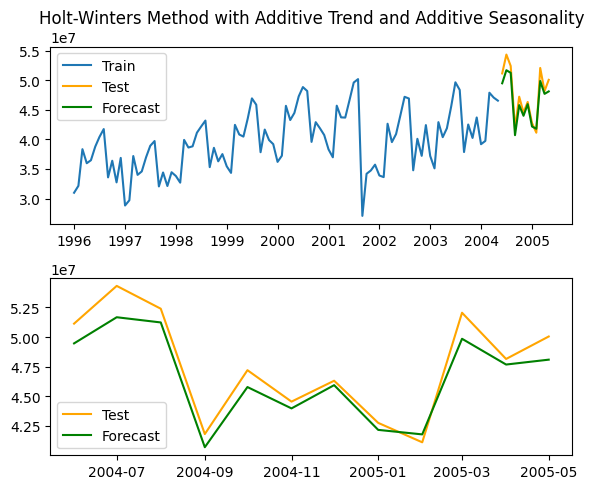

Model 1 - Evaluation Metrics
MAE: 1235752.70
RMSE: 1428832.83
MAPE: 2.52 %



In [10]:
plot_and_evaluate_forecast(train, test, forecast_1, "Holt-Winters Method with Additive Trend and Additive Seasonality", "Model 1")

#### **Holt-Winters Method with Additive Trend and Multiplicative Seasonality**

In [11]:
# lets apply holts-winter method
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_2 = ExponentialSmoothing(train, trend= 'add', seasonal="mul", seasonal_periods=12).fit()
forecast_2 = model_2.forecast(steps=len(test))
forecast_2

c:\Users\rajar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2004-06-01   49850307.86
2004-07-01   52242785.97
2004-08-01   52361680.54
2004-09-01   41365962.26
2004-10-01   46180456.52
2004-11-01   43508855.94
2004-12-01   45643695.96
2005-01-01   41233145.73
2005-02-01   40828505.30
2005-03-01   50239409.85
2005-04-01   47672748.14
2005-05-01   48181329.55
Freq: MS, dtype: float64

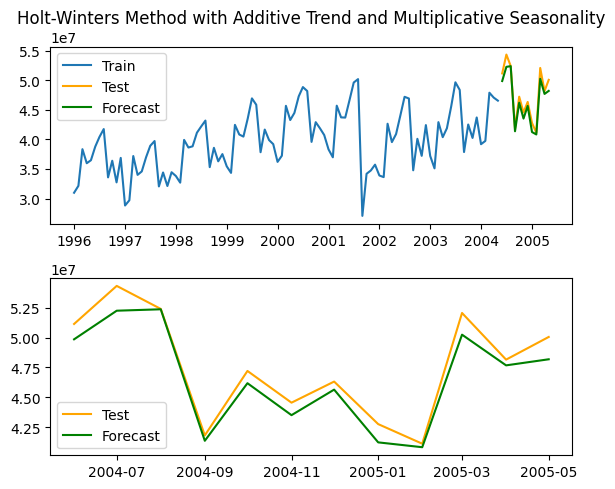

Model 2 - Evaluation Metrics
MAE: 1046933.53
RMSE: 1230641.26
MAPE: 2.16 %



In [12]:
plot_and_evaluate_forecast(train, test, forecast_2, "Holt-Winters Method with Additive Trend and Multiplicative Seasonality", "Model 2")

#### **Holt-Winters Method with Multiplicative Trend and Additive Seasonality**

In [13]:
# lets apply holts-winter method
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_3 = ExponentialSmoothing(train, trend= 'mul', seasonal="add", seasonal_periods=12).fit()
forecast_3 = model_3.forecast(steps=len(test))
forecast_3

c:\Users\rajar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2004-06-01   49509339.36
2004-07-01   51738372.81
2004-08-01   51322175.24
2004-09-01   40819332.86
2004-10-01   45918819.51
2004-11-01   44141697.69
2004-12-01   46128286.98
2005-01-01   42380595.22
2005-02-01   42026848.24
2005-03-01   50121302.37
2005-04-01   47974909.80
2005-05-01   48420448.10
Freq: MS, dtype: float64

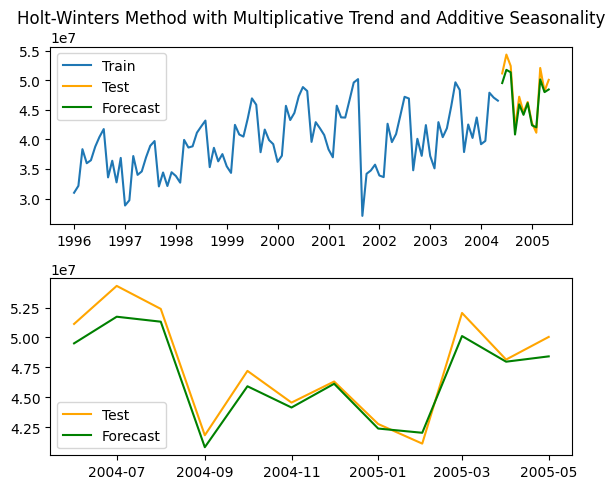

Model 3 - Evaluation Metrics
MAE: 1098498.19
RMSE: 1312454.71
MAPE: 2.24 %



In [14]:
plot_and_evaluate_forecast(train, test, forecast_3, "Holt-Winters Method with Multiplicative Trend and Additive Seasonality", "Model 3")

#### **Holt-Winters Method with Multiplicative Trend and Multiplicative Seasonality**

In [15]:
# lets apply holts-winter method
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_4 = ExponentialSmoothing(train, trend= 'mul', seasonal="mul", seasonal_periods=12).fit()
forecast_4 = model_4.forecast(steps=len(test))
forecast_4

c:\Users\rajar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2004-06-01   49898141.74
2004-07-01   52320200.04
2004-08-01   52467311.42
2004-09-01   41472312.38
2004-10-01   46322496.49
2004-11-01   43665428.34
2004-12-01   45832976.20
2005-01-01   41427595.46
2005-02-01   41044538.02
2005-03-01   50534231.84
2005-04-01   47980551.34
2005-05-01   48524053.66
Freq: MS, dtype: float64

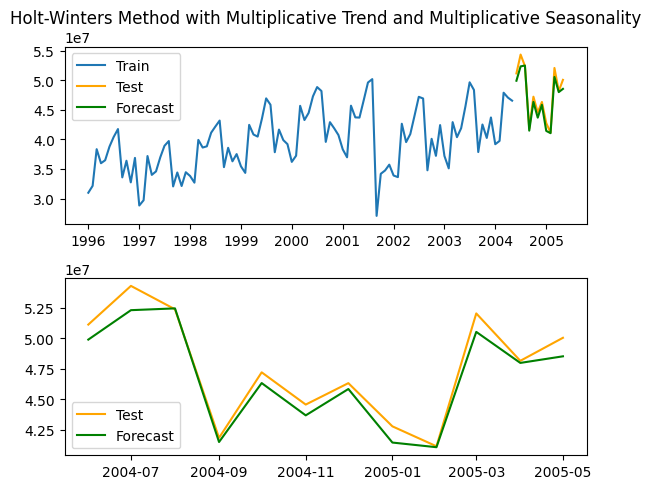

Model 4 - Evaluation Metrics
MAE: 877575.16
RMSE: 1075653.07
MAPE: 1.80 %



In [16]:
plot_and_evaluate_forecast(train, test, forecast_4, "Holt-Winters Method with Multiplicative Trend and Multiplicative Seasonality", "Model 4")

#### **Final Model Selection and Justification**
#### After running all four models, I compared their performance based on the evaluation metrics:
#### **1- MAE (Mean Absolute Error):** Measures the average magnitude of the errors in a set of forecasts, without considering their direction.
#### **2- RMSE (Root Mean Square Error):** Measures the square root of the average squared differences between forecasted and observed values.
#### **3- MAPE (Mean Absolute Percentage Error):** Measures the accuracy of the forecast as a percentage.

#### **Model Performance Comparison:**
#### &nbsp;&nbsp;&nbsp;&nbsp;Model 1 (Additive Trend, Additive Seasonality):
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MAE: 1235752.70
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RMSE: 1428832.83
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MAPE: 2.52%
#### &nbsp;&nbsp;&nbsp;&nbsp;Model 2 (Additive Trend, Multiplicative Seasonality):
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MAE: 1046933.53
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RMSE: ,236641.26
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MAPE: 2.16%
#### &nbsp;&nbsp;&nbsp;&nbsp;Model 3 (Multiplicative Trend, Additive Seasonality):
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MAE: 1098498.19
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RMSE: 1312454.71
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MAPE: 2.24%
#### &nbsp;&nbsp;&nbsp;&nbsp;Model 4 (Multiplicative Trend, Multiplicative Seasonality):
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MAE: 877575.16
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RMSE: 1075653.07
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MAPE: 1.80%

#### Model 4, which used a multiplicative trend and multiplicative seasonality, performed the best across all metrics. This result was consistent with my initial hypothesis that the airline miles data would benefit from a model that accounts for proportional changes in both trend and seasonality. The superior performance of Model 4 in terms of MAE, RMSE, and MAPE validated this approach, making it the best choice for future forecasting.

#### **Final step is predicitng the future.**
#### Here I used the model 4 (multiplicative treand and multiplicative seasonality) for my final predictions of the future. And below u can the predictions for next 12 months and also viusalization for this. From plot it is very clear the model is almost behaving like original time series, which is a good sign to rely on.

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_5 = ExponentialSmoothing(df, trend= 'mul', seasonal="mul", seasonal_periods=12).fit()
forecast_5 = model_5.forecast(steps=12)
forecast_5

c:\Users\rajar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2005-06-01   53177046.06
2005-07-01   55856837.67
2005-08-01   55599798.59
2005-09-01   43746278.83
2005-10-01   49228223.07
2005-11-01   46559351.22
2005-12-01   48857964.87
2006-01-01   44294774.51
2006-02-01   43671897.58
2006-03-01   53977465.00
2006-04-01   51125198.99
2006-05-01   51788267.17
Freq: MS, dtype: float64

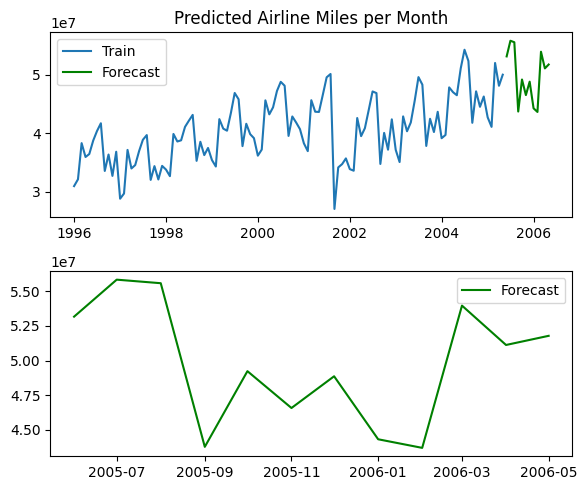

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5))

axs[0].plot(df, label='Train')
axs[0].plot(forecast_5, label='Forecast', color='green')
axs[0].legend(loc='best')
axs[0].set_title('Predicted Airline Miles per Month')

axs[1].plot(forecast_5, label='Forecast', color='green')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()